**Ann Classification**


In [134]:
from sklearn.calibration import LabelEncoder
import torch
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset


In [135]:
data = pd.read_csv("loan_data.csv")
targets = data['loan_status']

data.drop('loan_status', axis=1, inplace=True)

In [136]:
encoder = LabelEncoder()
data["person_gender"] = encoder.fit_transform(data['person_gender'])
data["person_education"] = encoder.fit_transform(data['person_education'])
data["person_home_ownership"] = encoder.fit_transform(data['person_home_ownership'])
data["loan_intent"] = encoder.fit_transform(data['loan_intent'])
data['previous_loan_defaults_on_file'] = encoder.fit_transform(data['previous_loan_defaults_on_file'])

In [137]:
scaler = StandardScaler()
data = scaler.fit_transform(data)



In [138]:
X_train, X_test, Y_train, Y_test = train_test_split(data, targets, test_size=0.2, random_state=42)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
Y_train = torch.LongTensor(Y_train.values)
Y_test = torch.LongTensor(Y_test.values)

In [139]:
class Classification(nn.Module):
    def __init__(self, input_dim, hidden1, hidden2, hidden3, output_dim):
        super(Classification, self).__init__()
        self.W1 = nn.Parameter(torch.randn(input_dim, hidden1) * 0.01)
        self.b1 = nn.Parameter(torch.zeros(hidden1))
        self.W2 = nn.Parameter(torch.randn(hidden1, hidden2) * 0.01)
        self.b2 = nn.Parameter(torch.zeros(hidden2))
        self.W3 = nn.Parameter(torch.randn(hidden2, hidden3) * 0.01)
        self.b3 = nn.Parameter(torch.zeros(hidden3))
        self.W_out = nn.Parameter(torch.randn(hidden3, output_dim) * 0.01)
        self.b_out = nn.Parameter(torch.zeros(output_dim))
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, X):
        x = self.relu(torch.mm(X, self.W1) + self.b1)
        x = self.relu(torch.mm(x, self.W2) + self.b2)
        x = self.relu(torch.mm(x, self.W3) + self.b3)
        x = self.sigmoid(torch.mm(x, self.W_out) + self.b_out)
        return x

In [140]:
output_dim = len(targets.unique())
input_dim = X_train.shape[1]
hidden1 = 10
hidden2 = 19
hidden3 = 20

In [146]:
model = Classification(input_dim, hidden1, hidden2, hidden3, output_dim)

criterion = nn.CrossEntropyLoss()
learning_rate = 0.001

In [147]:
# %%

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

loss = []

batch_size = 32
epochs = 50

train_data = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Define the training function
def train_model(epochs):
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        epoch_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            batch_loss = criterion(outputs, labels)
            batch_loss.backward()
            optimizer.step()
            epoch_loss += batch_loss.item()
        loss.append(epoch_loss/len(train_loader))

# Train the model
train_model(epochs)
print(loss)

[0.6878395791583591, 0.6777228770256043, 0.6683650777075025, 0.6597440899213155, 0.6518252861764696, 0.6445663446320428, 0.6379215644730462, 0.6318432089487711, 0.6262830197016398, 0.6211948981285095, 0.61653508149253, 0.6122640384038289, 0.6083444096777174, 0.6047422703107198, 0.6014260750346714, 0.598368497742547, 0.5955447491539849, 0.5929322324328953, 0.5905109973483615, 0.5882628021505144, 0.5861717038154602, 0.5842234858936733, 0.5824049912028842, 0.5807051318751442, 0.5791133839554257, 0.5776205458376142, 0.5762182708316379, 0.5748989850680033, 0.573656038681666, 0.5724834767182668, 0.5713757232030233, 0.5703279019726647, 0.5693355394204458, 0.5683944316440158, 0.5675007921324836, 0.5666513656510247, 0.5658430347442627, 0.5650729660458035, 0.5643385895623101, 0.5636374744574228, 0.5629674997329712, 0.562326807392968, 0.5617134230136871, 0.5611257780657875, 0.5605622866418627, 0.5600213935375213, 0.5595018736521403, 0.5590024076037937, 0.5585219590134091, 0.558059432135688]


In [ ]:
model.eval()
with torch.no_grad():
    logits = model(X_test)
    predicted_classes = torch.argmax(logits, dim=1)

    # Convert PyTorch tensors to NumPy arrays
    predicted_classes_np = predicted_classes.cpu().numpy()  # Ensure it's on CPU
    Y_test_np = Y_test.cpu().numpy()  # Convert Y_test to NumPy (if it's a tensor)

    # Compute metrics
    print("F1 Score:", f1_score(Y_test_np, predicted_classes_np, average='weighted'))
    print("Recall Score:", recall_score(Y_test_np, predicted_classes_np, average='weighted'))
    print("Precision Score:", precision_score(Y_test_np, predicted_classes_np, average='weighted'))
    print("Confusion Matrix:\n", confusion_matrix(Y_test_np, predicted_classes_np))

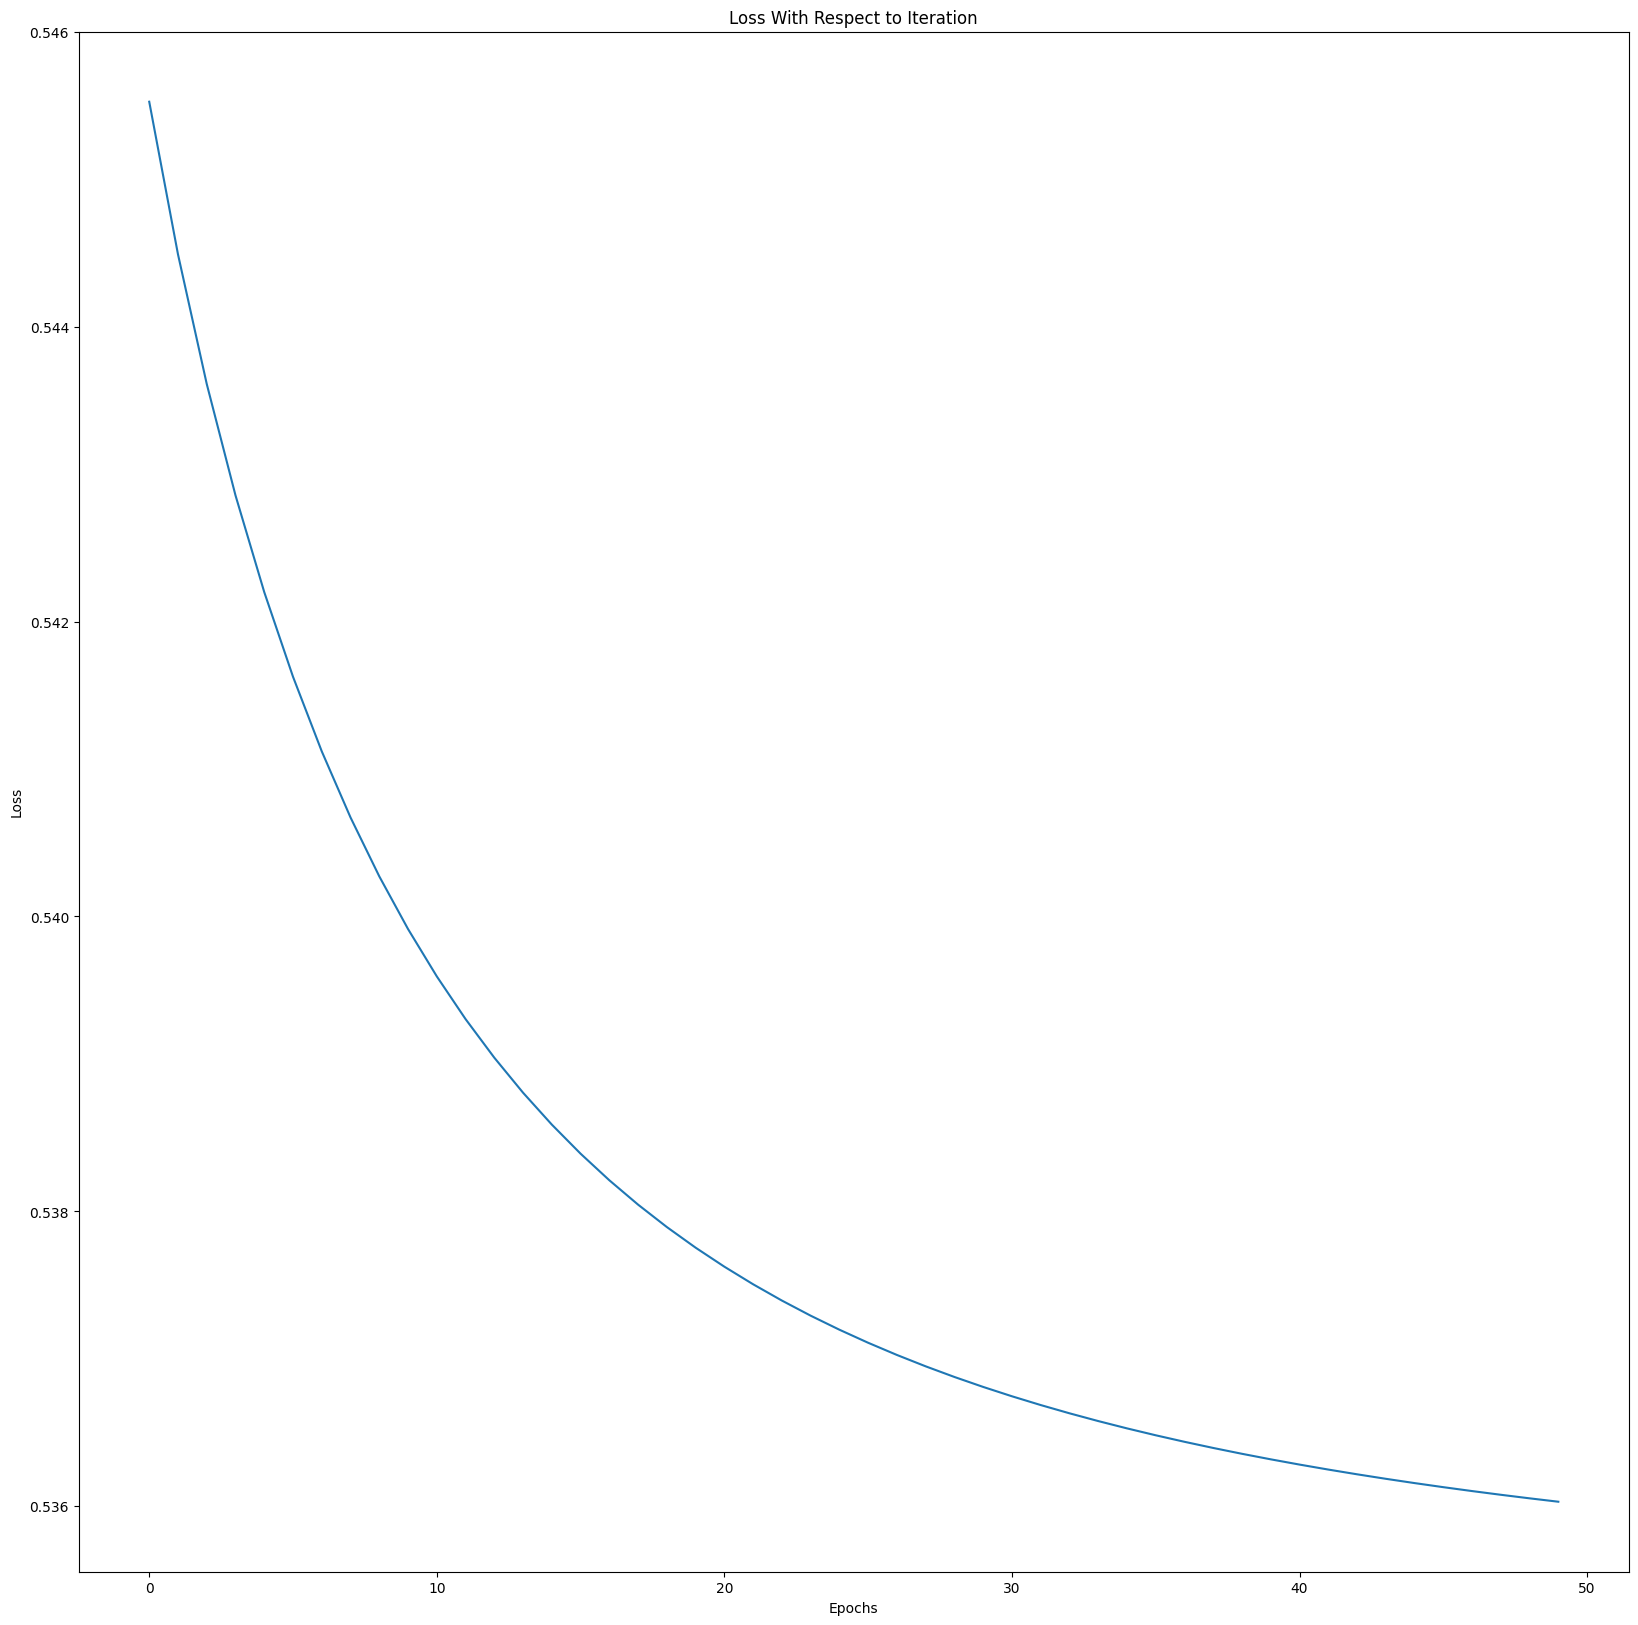

In [145]:
import matplotlib.pyplot as plt
loss_values = [l for l in loss]
plt.figure(figsize=(20, 20))
plt.title("Loss With Respect to Iteration")
plt.plot(range(len(loss_values)), loss_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()